In [3]:
#Import my dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
## bunu (0,1) set ederel min 0 max 1 olacaka sekilde scale et diyoruz
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf
tf.__version__

'2.9.1'

In [44]:
df = pd.read_csv('AAPL.csv')
df_btc = pd.read_csv('../price_app2/BTC-USD.csv')
df_btc.columns = map(str.lower, df_btc.columns)
df_btc = df_btc.drop('adj close', axis=1)
df_btc['Name'] = 'BTC'
df_btc.head()

,date,open,high,low,close,volume,Name
0,2017-07-23,2808.100098,2832.179932,2653.939941,2730.399902,1072840000,BTC
1,2017-07-24,2732.699951,2777.260010,2699.189941,2754.860107,866473984,BTC
2,2017-07-25,2757.500000,2768.080078,2480.959961,2576.479980,1460089984,BTC
3,2017-07-26,2577.770020,2610.760010,2450.800049,2529.449951,937404032,BTC
4,2017-07-27,2538.709961,2693.320068,2529.340088,2671.780029,789104000,BTC


In [45]:
#preprocessing our data
df = df['open'].values
df = df.reshape(-1,1)   ### bu reshaoe nasil calisir
print(df.shape)

df_btc = df_btc['open'].values
df_btc = df_btc.reshape(-1,1)
df_btc.shape

(1259, 1)


(1259, 1)

In [46]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print(dataset_train.shape)
print(dataset_test.shape)

#####BTC
dataset_train_btc = np.array(df_btc[:int(df_btc.shape[0]*0.8)])
dataset_test_btc = np.array(df_btc[int(df_btc.shape[0]*0.8)-50:])
print(dataset_train_btc.shape)
print(dataset_test_btc.shape)

(1007, 1)
(302, 1)
(1007, 1)
(302, 1)


In [47]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)

####btc
dataset_train_btc = scaler.fit_transform(dataset_train_btc)
dataset_train_btc[:7]
dataset_train[:7]

array([[0.15550899],
       [0.16002875],
       [0.16546966],
       [0.1432353 ],
       [0.13837263],
       [0.14619996],
       [0.1321915 ]])

In [48]:
dataset_test = scaler.transform(dataset_test)

dataset_test_btc = scaler.transform(dataset_test_btc)

dataset_test[:7]

array([[-0.14332922],
       [-0.1433115 ],
       [-0.14334988],
       [-0.14330147],
       [-0.14337438],
       [-0.14344494],
       [-0.14339593]])

In [49]:
def create_my_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [50]:
x_train, y_train = create_my_dataset(dataset_train)

x_train_btc, y_train_btc = create_my_dataset(dataset_train_btc)
x_train[:1]

array([[0.15550899, 0.16002875, 0.16546966, 0.1432353 , 0.13837263,
        0.14619996, 0.1321915 , 0.12602681, 0.10489581, 0.11077074,
        0.11908522, 0.10095558, 0.10928904, 0.10137187, 0.09043563,
        0.07199725, 0.06057385, 0.08412669, 0.06603248, 0.07561229,
        0.07552245, 0.08609681, 0.07317274, 0.0810899 , 0.09030909,
        0.09667117, 0.12929896, 0.1255384 , 0.11252448, 0.12040496,
        0.13868011, 0.14003654, 0.12380363, 0.11180072, 0.09748478,
        0.07163663, 0.07845043, 0.08277153, 0.06603248, 0.06666515,
        0.06939446, 0.07254007, 0.08269814, 0.08347632, 0.07055098,
        0.06073581, 0.0583861 , 0.03076649, 0.        , 0.00844228]])

In [51]:
y_train[:1]

array([0.02895833])

In [52]:
x_test, y_test = create_my_dataset(dataset_test)

x_test_btc, y_test_btc = create_my_dataset(dataset_test_btc)
x_test[:1]

array([[-0.14332922, -0.1433115 , -0.14334988, -0.14330147, -0.14337438,
        -0.14344494, -0.14339593, -0.14342546, -0.14343963, -0.14334516,
        -0.14325955, -0.14320169, -0.14316921, -0.14309836, -0.14307829,
        -0.14301393, -0.14305349, -0.14299799, -0.14299445, -0.14302102,
        -0.14306589, -0.14301098, -0.14295194, -0.14301511, -0.1430033 ,
        -0.14305349, -0.14305054, -0.14304641, -0.14299563, -0.14292655,
        -0.14287814, -0.14287991, -0.14287076, -0.14285806, -0.14290352,
        -0.14280551, -0.14284094, -0.14277895, -0.14280551, -0.14283208,
        -0.14278072, -0.14270691, -0.14267916, -0.1427506 , -0.14273762,
        -0.14239045, -0.14233465, -0.14231487, -0.14226646, -0.14218321]])

In [53]:
#reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

x_train_btc = np.reshape(x_train_btc, (x_train_btc.shape[0],x_train_btc.shape[1],1))
x_test_btc = np.reshape(x_test_btc, (x_test_btc.shape[0], x_test_btc.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(957, 50, 1)
(252, 50, 1)


In [54]:
# tf.logging.set_verbosity(tf.logging.ERROR)
model = Sequential()
#3## input shape olarak 50 geldi kac gunle degerlendirecegiz
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2022-08-31 22:40:02.036971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-31 22:40:02.104482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-31 22:40:02.104564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-31 22:40:02.107438: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [56]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [57]:
if(not os.path.exists(r'/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/TF_Deep_Learing_book/lstm_stock_udemy/stock_prediction.h5')):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save(r'/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/TF_Deep_Learing_book/lstm_stock_udemy/stock_prediction.h5')

Epoch 1/50


2022-08-31 22:44:18.823955: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


30/30 [==============================] - 6s 21ms/step - loss: 0.0445
Epoch 2/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0063
Epoch 3/50
30/30 [==============================] - 1s 20ms/step - loss: 0.0053
Epoch 4/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0047
Epoch 5/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0048
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0043
Epoch 7/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0041
Epoch 8/50
30/30 [==============================] - 0s 15ms/step - loss: 0.0040
Epoch 9/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 10/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0051
Epoch 11/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0039
Epoch 12/50
30/30 [==============================] - 0s 16ms/step - loss: 0.0038
Epoch 13/50
30/30 [=============================

In [58]:
model = load_model(r'/mnt/c/Users/kozan/Desktop/Sen_Des_Proj/TF_Deep_Learing_book/lstm_stock_udemy/stock_prediction.h5')

8/8 [==============================] - 1s 19ms/step
range(1007, 1259)


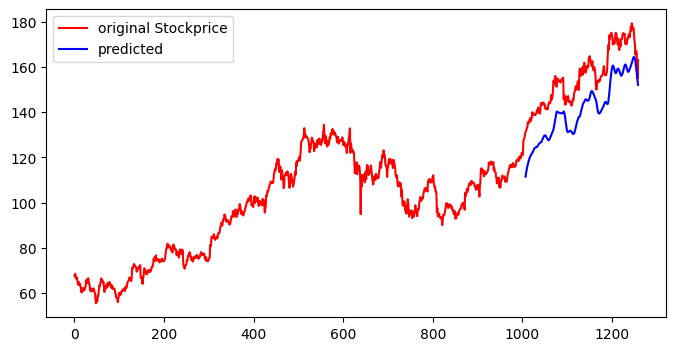

In [59]:
#visualizing our predictions
%matplotlib inline
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df, color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted')
plt.legend()
print(range(len(y_train)+50, len(y_train)+50+len(predictions)))

8/8 [==============================] - 0s 20ms/step
range(1007, 1259)


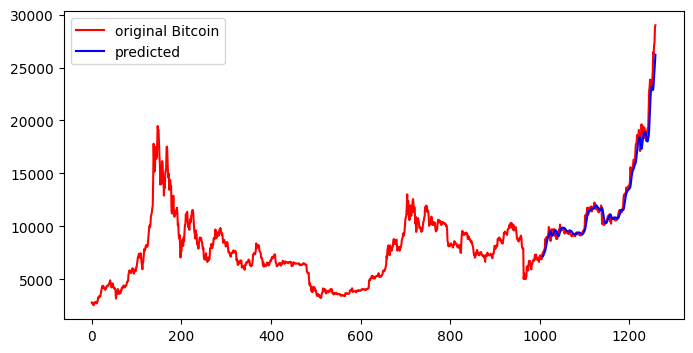

In [60]:
%matplotlib inline
predictions_btc = model.predict(x_test_btc)
predictions_btc = scaler.inverse_transform(predictions_btc)

fig, ax = plt.subplots(figsize=(8,4))
plt.plot(df_btc, color='red', label='original Bitcoin')
ax.plot(range(len(y_train_btc)+50, len(y_train_btc)+50+len(predictions_btc)),predictions_btc,color='blue', label='predicted')
plt.legend()
print(range(len(y_train_btc)+50, len(y_train_btc)+50+len(predictions_btc)))

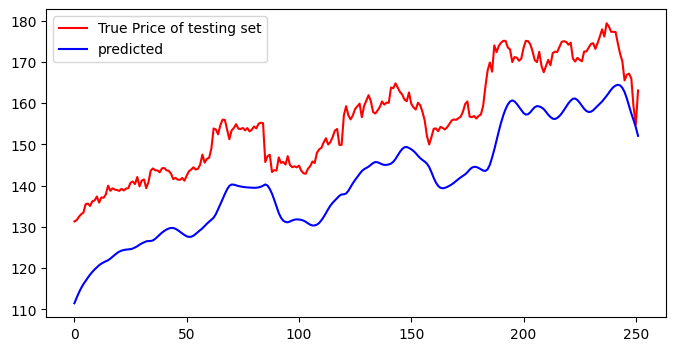

In [61]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red', label = 'True Price of testing set')
plt.plot(predictions, color = 'blue', label='predicted')
plt.legend()

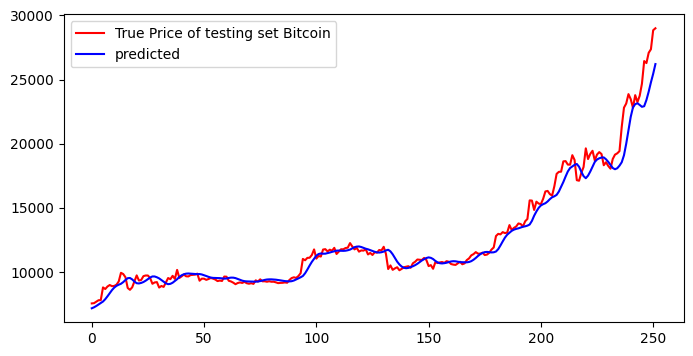

In [62]:
y_test_scaled_btc = scaler.inverse_transform(y_test_btc.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled_btc, color='red', label = 'True Price of testing set Bitcoin')
plt.plot(predictions_btc, color = 'blue', label='predicted')
plt.legend()